# PyMC model

This notebook shows a PyMC model that incorporates basket + clustering

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import exists

sys.path.append('..')
sys.path.append('.')

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.metrics import mean_squared_error
from scipy.stats import halfnorm
import math
from statsmodels.formula.api import glm
import statsmodels.api as sm
import seaborn as sns

from scipy import stats
from scipy.special import expit as logistic

In [4]:
from pyBasket.common import load_obj
from pyBasket.preprocessing import get_pivot_count_df
from pyBasket.model import get_patient_model_simple, get_patient_model_hierarchical
from pyBasket.model import get_patient_model_hierarchical_log_odds, get_patient_model_hierarchical_log_odds_nc
from pyBasket.model import get_model_simple, get_model_bhm, get_model_bhm_nc

## 1. Generate some data

In [5]:
np.random.seed(42)

New generative process

In [6]:
# Define number of patients, tissues, and clusters
n_patients = 500
n_tissues = 25
n_clusters = 10

# Generate tissue and cluster indices for each patient
basket_coords = np.arange(n_tissues)
cluster_coords = np.arange(n_clusters)
basket_idx = np.random.choice(basket_coords, size=n_patients)
cluster_idx = np.random.choice(cluster_coords, size=n_patients)

# Generate synthetic responsiveness data
theta_basket = np.random.normal(loc=0, scale=2, size=n_tissues)

# Generate unique prior mean and std for each column in theta_cluster
prior_means = np.random.normal(loc=0, scale=2, size=n_clusters)
prior_std_mean = 0 # mean of the half-normal distribution
prior_std_std = 1 # standard deviation of the half-normal distribution
prior_std_scale = np.sqrt(2) * prior_std_std / np.pi
prior_stds = halfnorm.rvs(loc=prior_std_mean, scale=prior_std_scale, size=n_clusters)

theta_cluster = np.zeros((n_tissues, n_clusters))
for i in range(n_clusters):
    theta_cluster[:,i] = np.random.normal(loc=prior_means[i], scale=prior_stds[i], size=n_tissues)

true_basket_p = logistic(theta_basket)
true_cluster_p = logistic(theta_cluster)
true_basket_reshaped = true_basket_p.reshape((n_tissues, 1))
true_mat = true_basket_reshaped * true_cluster_p

true_patient_p = true_mat[basket_idx, cluster_idx]
is_responsive = np.random.binomial(n=1, p=true_patient_p)

# Create synthetic data dataframe
data_df = pd.DataFrame({
    'basket_number': basket_idx,
    'cluster_number': cluster_idx,
    'responsive': is_responsive
})

# Print the first few rows of the data dataframe
data_df

,basket_number,cluster_number,responsive
0,6,6,0
1,19,3,0
2,14,0,0
3,10,4,1
4,7,6,0
...,...,...,...
495,4,8,0
496,11,4,0
497,15,2,0
498,15,4,0


In [7]:
true_basket_df = pd.DataFrame({'prob': true_basket_p, 'basket': range(len(true_basket_p))})

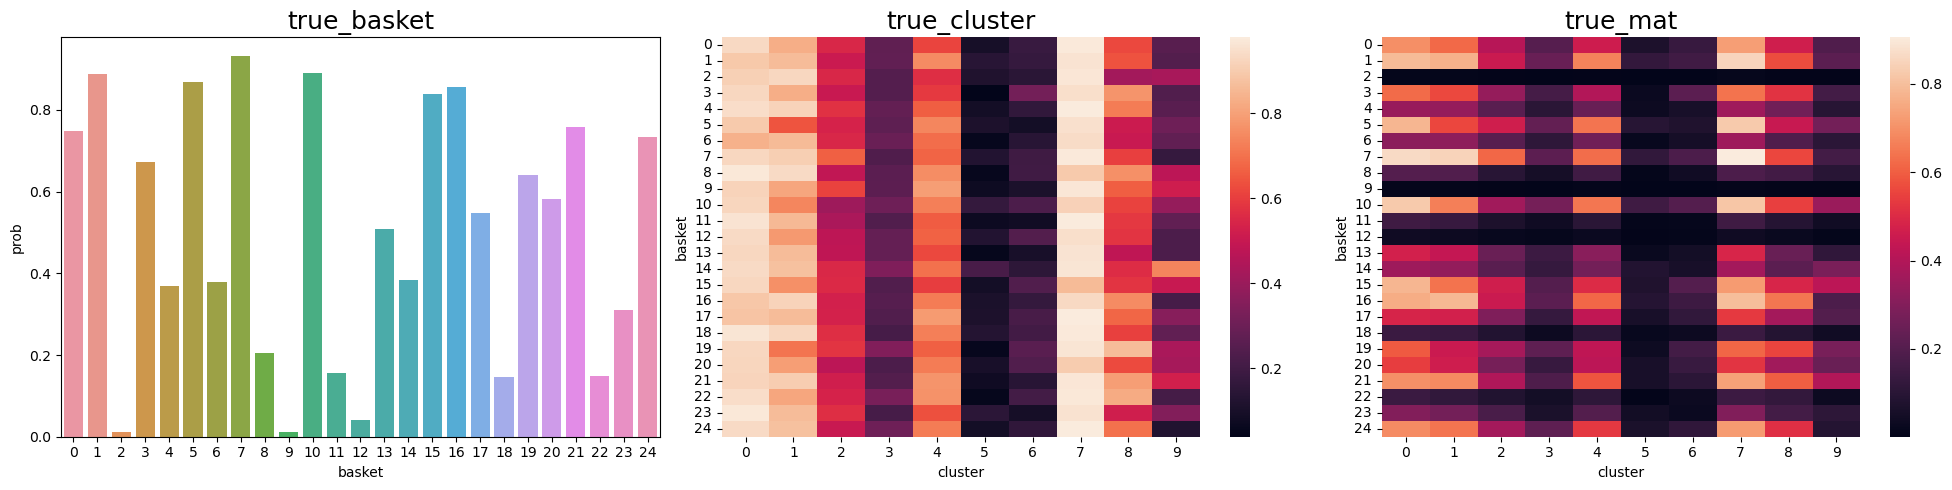

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

sns.barplot(data=true_basket_df, x='basket', y='prob', ax=ax1)
sns.heatmap(true_cluster_p, ax=ax2)
sns.heatmap(true_mat, ax=ax3)

ax1.set_title('true_basket', fontsize=18)
ax2.set_title('true_cluster', fontsize=18)
ax2.set_xlabel('cluster')
ax2.set_ylabel('basket')
ax3.set_title('true_mat', fontsize=18)
ax3.set_xlabel('cluster')
ax3.set_ylabel('basket')
plt.tight_layout()

Convert data_df into the format some models want.

In [9]:
df_pivot = get_pivot_count_df(data_df)
df_pivot

,n_success,n_trial
basket_number,,
0,12,30
1,13,20
2,0,28
3,6,16
4,1,21
5,8,14
6,4,23
7,13,23
8,0,18


## 2. Define models

No. of samples to collect before and after burn-in during MCMC.

In [10]:
n_burn_in = int(5E3)
n_sample = int(5E3)
target_accept = 0.99

### Simple model

In [11]:
model_s = get_model_simple(df_pivot)

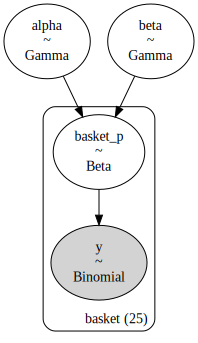

In [12]:
pm.model_to_graphviz(model_s)

In [13]:
with model_s:
    trace_s = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, basket_p]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 36 seconds.


In [14]:
az.summary(trace_s).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.48,0.51,0.63,2.43,0.01,0.00,6043.0,8497.0,1.0
beta,4.03,1.42,1.71,6.70,0.02,0.01,6862.0,9179.0,1.0
basket_p[0],0.38,0.08,0.23,0.53,0.00,0.00,30559.0,14873.0,1.0
basket_p[1],0.57,0.10,0.38,0.75,0.00,0.00,18854.0,14185.0,1.0
basket_p[2],0.04,0.04,0.00,0.11,0.00,0.00,14559.0,10221.0,1.0
basket_p[3],0.35,0.10,0.17,0.54,0.00,0.00,22059.0,14559.0,1.0
basket_p[4],0.09,0.06,0.00,0.20,0.00,0.00,20754.0,12141.0,1.0
basket_p[5],0.49,0.11,0.28,0.70,0.00,0.00,22999.0,13800.0,1.0
basket_p[6],0.19,0.07,0.06,0.33,0.00,0.00,25715.0,13543.0,1.0
basket_p[7],0.51,0.09,0.34,0.69,0.00,0.00,21141.0,15410.0,1.0


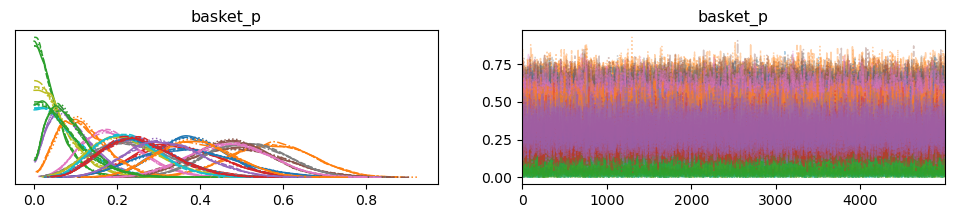

In [15]:
az.plot_trace(trace_s, var_names=['basket_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

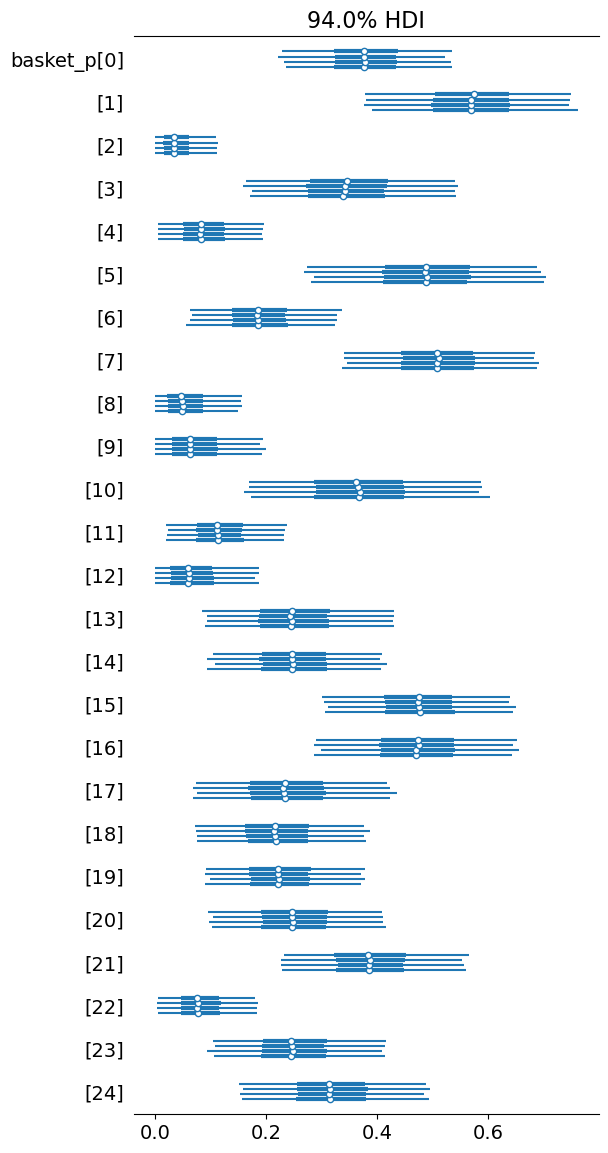

In [16]:
az.plot_forest(trace_s, var_names=['basket_p'])

In [17]:
stacked_s = az.extract(trace_s)

In [18]:
inferred_basket_p = np.mean(stacked_s.basket_p.values, axis=1)
true_basket_p.shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

((25,), (25,), 0.2916013062132531)

### BHM (see Berry 2013)

In [19]:
model_bhm = get_model_bhm(df_pivot)

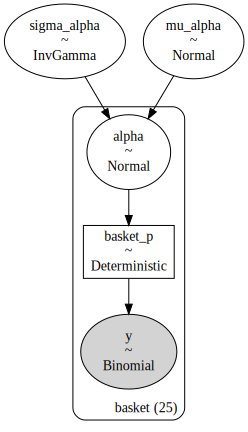

In [20]:
pm.model_to_graphviz(model_bhm)

This is what we actually run

In [21]:
model_bhm = get_model_bhm_nc(df_pivot)

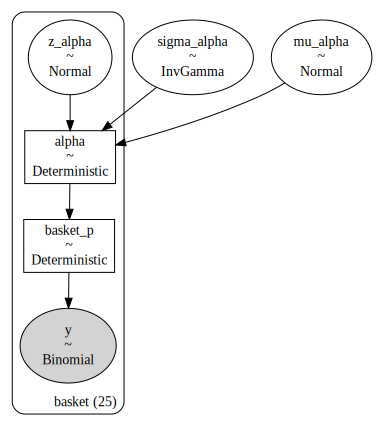

In [22]:
pm.model_to_graphviz(model_bhm)

In [23]:
with model_bhm:
    trace_h1 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_alpha, mu_alpha, sigma_alpha]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 43 seconds.


In [24]:
az.summary(trace_h1).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_alpha[0],0.64,0.38,-0.09,1.35,0.00,0.0,9370.0,12375.0,1.0
z_alpha[1],1.38,0.47,0.51,2.25,0.00,0.0,8137.0,12335.0,1.0
z_alpha[2],-1.63,0.66,-2.86,-0.41,0.01,0.0,14315.0,13641.0,1.0
z_alpha[3],0.49,0.46,-0.37,1.37,0.00,0.0,13064.0,13586.0,1.0
z_alpha[4],-1.03,0.60,-2.18,0.04,0.00,0.0,16389.0,13396.0,1.0
...,...,...,...,...,...,...,...,...,...
basket_p[20],0.25,0.09,0.09,0.41,0.00,0.0,28519.0,14973.0,1.0
basket_p[21],0.39,0.09,0.22,0.56,0.00,0.0,28576.0,15080.0,1.0
basket_p[22],0.08,0.05,0.01,0.18,0.00,0.0,21888.0,13779.0,1.0
basket_p[23],0.25,0.09,0.10,0.41,0.00,0.0,27927.0,15313.0,1.0


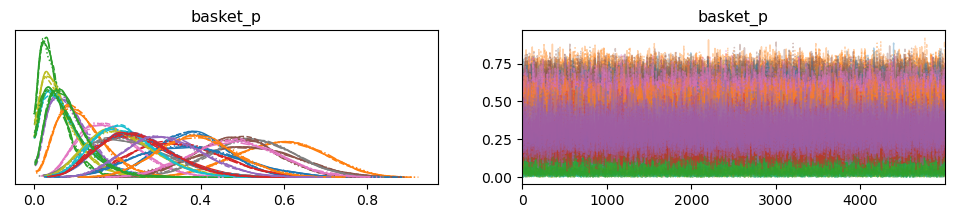

In [25]:
az.plot_trace(trace_h1, var_names=['basket_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

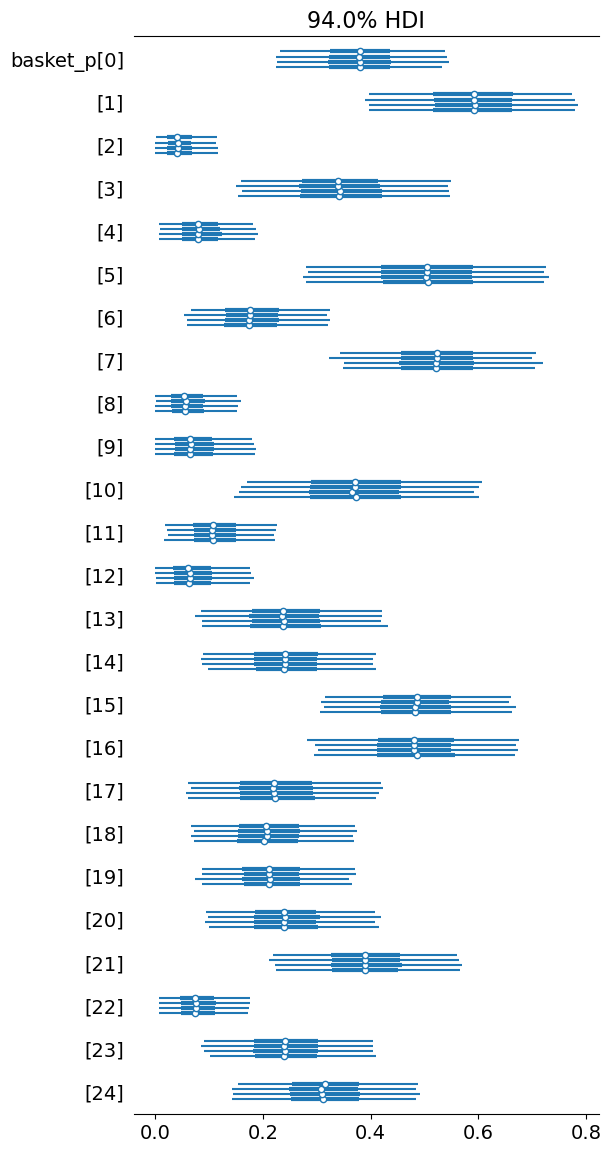

In [26]:
az.plot_forest(trace_h1, var_names=['basket_p'])

In [27]:
stacked_h1 = az.extract(trace_h1)

In [28]:
inferred_basket_p = np.mean(stacked_h1.basket_p.values, axis=1)
true_basket_p.shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

((25,), (25,), 0.2897439105551178)

### Hierarchical model 2

Another hierarchical model, but modelling the log-odds instead.

In [29]:
model_h2 = get_patient_model_hierarchical_log_odds(data_df)

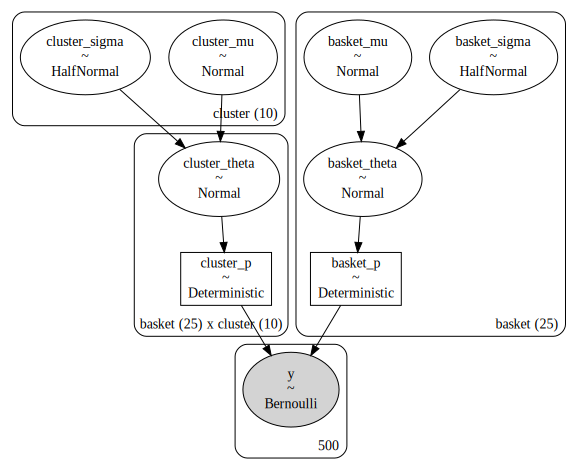

In [30]:
pm.model_to_graphviz(model_h2)

In [31]:
# with model_h2:
#     trace_h2 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

This is the one we actually use after reparameterisation.

In [32]:
model_h2_nc = get_patient_model_hierarchical_log_odds_nc(data_df)

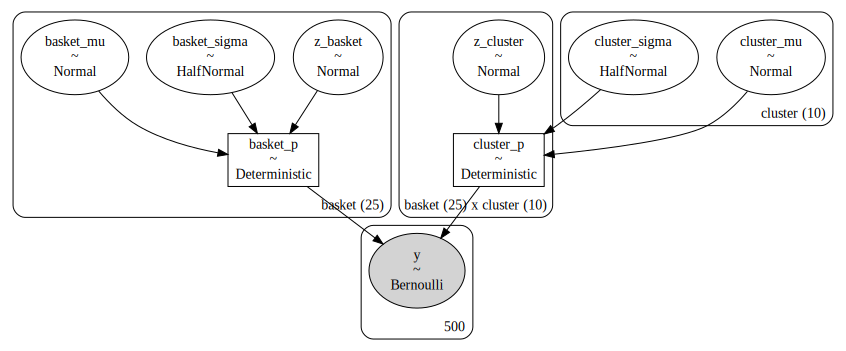

In [33]:
pm.model_to_graphviz(model_h2_nc)

In [34]:
with model_h2_nc:
    trace_h2 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_basket, z_cluster, basket_mu, cluster_mu, basket_sigma, cluster_sigma]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 167 seconds.


In [35]:
az.summary(trace_h2).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_basket[6],0.20,0.95,-1.58,2.02,0.01,0.01,26039.0,15310.0,1.0
z_basket[19],0.51,0.98,-1.36,2.32,0.01,0.01,23984.0,15921.0,1.0
z_basket[14],-0.56,0.99,-2.38,1.34,0.01,0.01,23070.0,15649.0,1.0
z_basket[10],0.12,0.94,-1.67,1.90,0.01,0.01,23088.0,15972.0,1.0
z_basket[7],-0.30,0.96,-2.09,1.49,0.01,0.01,22269.0,15082.0,1.0
...,...,...,...,...,...,...,...,...,...
"cluster_p[12, 5]",0.12,0.10,0.00,0.30,0.00,0.00,24898.0,16021.0,1.0
"cluster_p[12, 1]",0.25,0.17,0.00,0.55,0.00,0.00,25550.0,15702.0,1.0
"cluster_p[12, 2]",0.92,0.09,0.76,1.00,0.00,0.00,21034.0,14521.0,1.0
"cluster_p[12, 7]",0.59,0.18,0.24,0.94,0.00,0.00,18632.0,12988.0,1.0


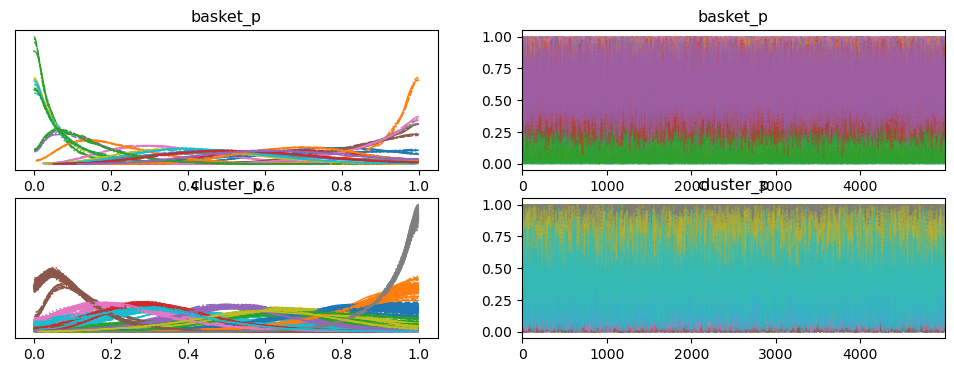

In [36]:
az.plot_trace(trace_h2, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

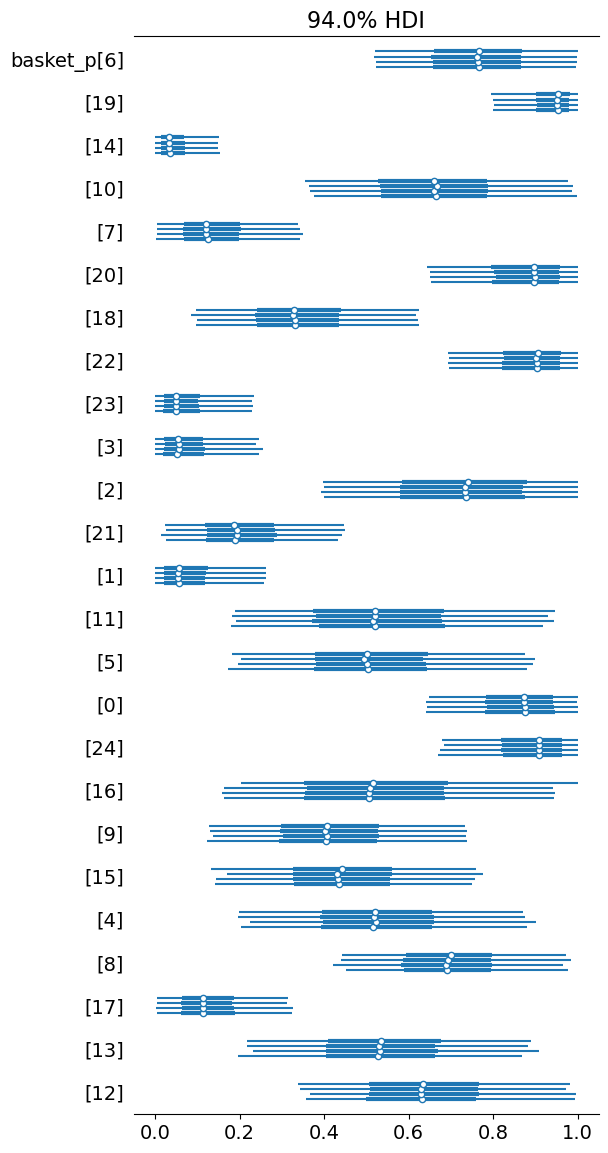

In [37]:
az.plot_forest(trace_h2, var_names=['basket_p'])

In [38]:
stacked_h2 = az.extract(trace_h2)

In [39]:
inferred_basket_p = np.mean(stacked_h2.basket_p.values, axis=1)
true_basket_p.shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

((25,), (25,), 0.11245426290673319)

In [40]:
inferred_cluster_p = np.mean(stacked_h2.cluster_p.values, axis=2)
true_cluster_p.shape, inferred_cluster_p.shape, math.sqrt(mean_squared_error(true_cluster_p, inferred_cluster_p))

((25, 10), (25, 10), 0.11434707761200234)

In [41]:
inferred_basket_p_tiled = np.tile(inferred_basket_p, (n_clusters, 1)).T
inferred_mat_h2 = inferred_basket_p_tiled * inferred_cluster_p
true_mat.shape, inferred_basket_p_tiled.shape, inferred_mat_h2.shape

((25, 10), (25, 10), (25, 10))

## 3. Calculate RMSE

Calculate root mean squared error for basket_p

In [42]:
sns.set_context('poster')

In [43]:
actual = true_basket_p

predicted_basket_s = np.mean(stacked_s.basket_p.values, axis=1)
predicted_basket_s_df = pd.DataFrame({'prob': predicted_basket_s, 'basket': range(len(predicted_basket_s))})
rmse_s = math.sqrt(mean_squared_error(actual, predicted_basket_s))

predicted_basket_h1 = np.mean(stacked_h1.basket_p.values, axis=1)
predicted_basket_h1_df = pd.DataFrame({'prob': predicted_basket_h1, 'basket': range(len(predicted_basket_h1))})
rmse_h1 = math.sqrt(mean_squared_error(actual, predicted_basket_h1))

predicted_basket_h2 = np.mean(stacked_h2.basket_p.values, axis=1)
predicted_basket_h2_df = pd.DataFrame({'prob': predicted_basket_h2, 'basket': range(len(predicted_basket_h2))})
rmse_h2 = math.sqrt(mean_squared_error(actual, predicted_basket_h2))

rmse_basket_p = pd.DataFrame({
    'method': ['Simple', 'BHM', 'pyBasket'],
    'RMSE': [rmse_s, rmse_h1, rmse_h2]
})
rmse_basket_p

,method,RMSE
0,Simple,0.291601
1,BHM,0.289744
2,pyBasket,0.112454


Calculate root mean squared error for cluster_p

In [44]:
actual = true_cluster_p

predicted_cluster_h2 = np.mean(stacked_h2.cluster_p.values, axis=2)
rmse_h2 = math.sqrt(mean_squared_error(actual, predicted_cluster_h2))

rmse_cluster_p = pd.DataFrame({
    'method': ['pyBasket'],
    'RMSE': [rmse_h2]
})
rmse_cluster_p

,method,RMSE
0,pyBasket,0.114347


Make plot

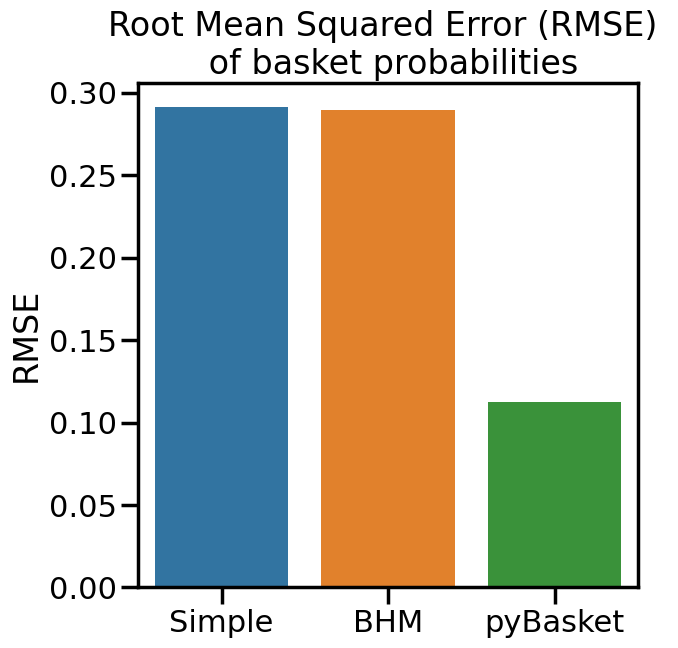

In [45]:
methods = rmse_basket_p['method'].unique()
colors = sns.color_palette("deep", len(methods))
color_map = dict(zip(methods, colors))

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))

sns.barplot(x='method', y='RMSE', data=rmse_basket_p, ax=ax1)
ax1.set_title('Root Mean Squared Error (RMSE) \n of basket probabilities')
plt.xlabel(None)
plt.tight_layout()
plt.savefig('results/report_rmse.png', dpi=300)

Compare the matrices

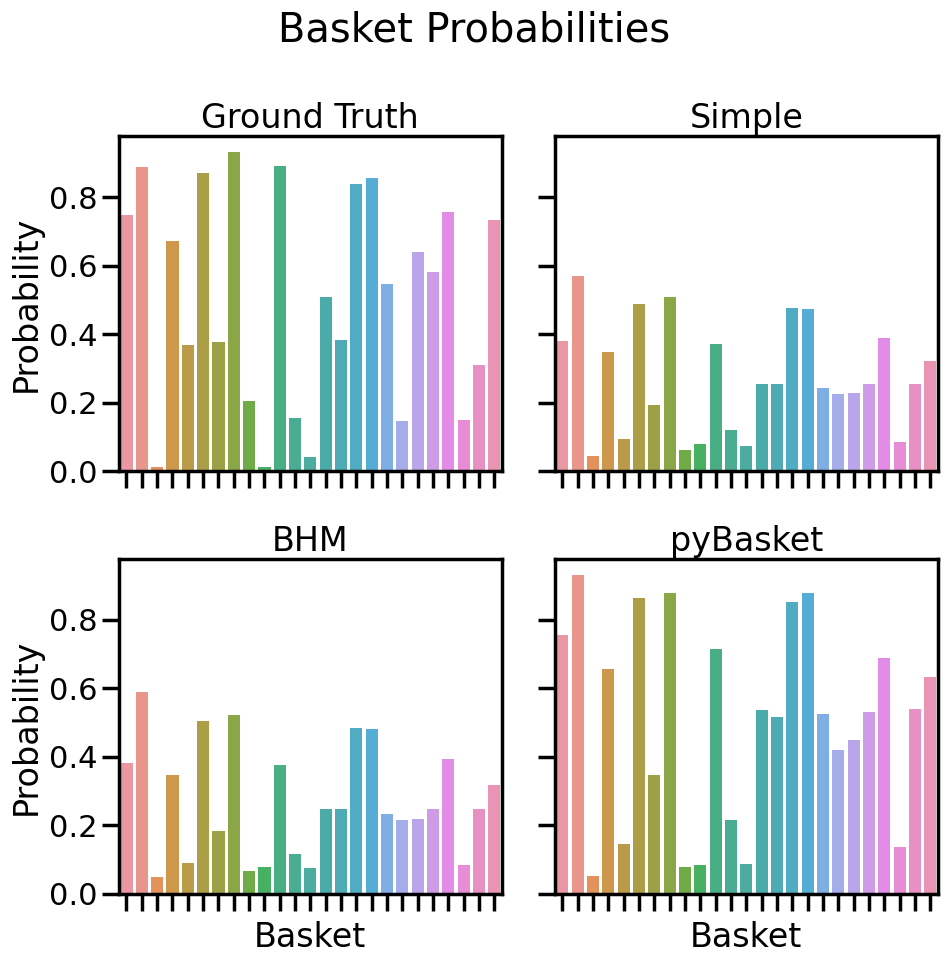

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

sns.barplot(data=true_basket_df, x='basket', y='prob', ax=ax[0][0])
ax[0][0].set_title('Ground Truth')
ax[0][0].set_xlabel(None)
ax[0][0].set_ylabel('Probability')

sns.barplot(data=predicted_basket_s_df, x='basket', y='prob', ax=ax[0][1])
ax[0][1].set_title('Simple')
ax[0][1].set_xlabel(None)
ax[0][1].set_ylabel(None)

sns.barplot(data=predicted_basket_h1_df, x='basket', y='prob', ax=ax[1][0])
ax[1][0].set_title('BHM')
ax[1][0].set_ylabel('Probability')
ax[1][0].set_xlabel('Basket')

sns.barplot(data=predicted_basket_h2_df, x='basket', y='prob', ax=ax[1][1])
ax[1][1].set_title('pyBasket')
ax[1][1].set_ylabel(None)
ax[1][1].set_xticklabels([])
ax[1][1].set_xlabel('Basket')

plt.suptitle('Basket Probabilities')
plt.tight_layout()
plt.savefig('results/report_synthetic_10_basket_probs.png', dpi=300)

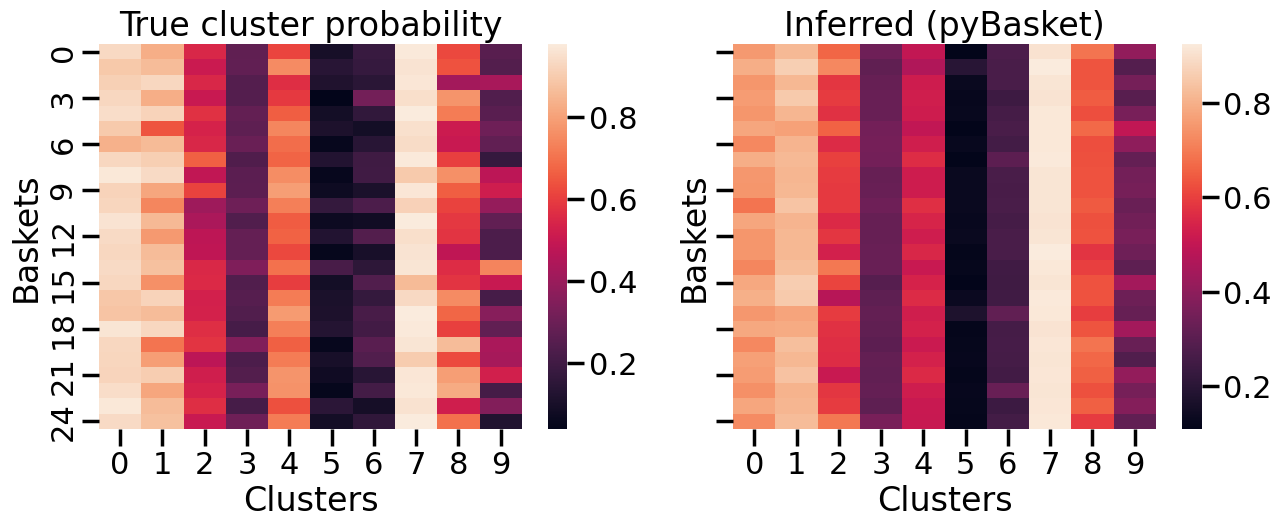

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

sns.heatmap(true_cluster_p, ax=ax[0])
ax[0].set_title('True cluster probability')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Baskets')
        
sns.heatmap(predicted_cluster_h2, ax=ax[1])
ax[1].set_title('Inferred (pyBasket)')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Baskets')
plt.savefig('results/report_synthetic_10_cluster_probs.png', dpi=300)

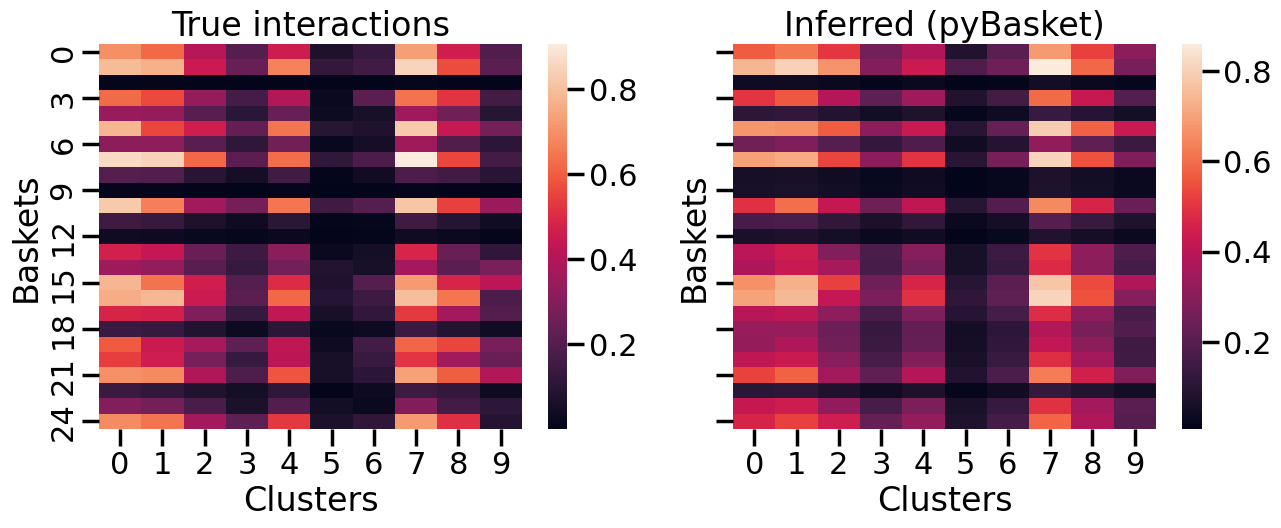

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

sns.heatmap(true_mat, ax=ax[0])
ax[0].set_title('True interactions')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Baskets')
        
sns.heatmap(inferred_mat_h2, ax=ax[1])
ax[1].set_title('Inferred (pyBasket)')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Baskets')
plt.savefig('results/report_synthetic_10_interactions.png', dpi=300)